In [1]:
import pandas as pd


df_final = pd.read_csv("/Users/loicalix-brown/OneDrive/FYP/Coding/DF/df_final_grid.csv")

In [2]:
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss
from matplotlib import pyplot
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import plot_roc_curve
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.pipeline import Pipeline 
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
from numpy import ravel
import numpy as np



/Users/loicalix-brown/opt/anaconda3/lib/python3.7/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/loicalix-brown/opt/anaconda3/lib/python3.7/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/loicalix-brown/opt/anaconda3/lib/python3.7/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 a

In [3]:
for i in range (len(df_final)):
    if (df_final.churned[i] > 1):
        df_final.churned[i] = 1

In [4]:
y = df_final.churned.value_counts()
print(y)

0.0    2604
1.0    1735
Name: churned, dtype: int64


In [5]:
X = df_final.iloc[:,-30:-2].values
print(X)

Y = df_final.iloc[:,-2:-1].values
print(Y)

[[ 8.         8.         2.        ...  0.         0.         0.       ]
 [ 0.         0.         0.        ...  0.         2.         0.       ]
 [20.         0.         9.        ...  0.         0.         0.       ]
 ...
 [ 2.         0.        34.        ...  0.         0.1767767  0.1767767]
 [ 0.         0.         0.        ...  0.         0.25       0.       ]
 [21.         0.         2.        ...  0.         0.25       0.       ]]
[[1.]
 [1.]
 [0.]
 ...
 [1.]
 [1.]
 [1.]]


In [6]:
xTrain_xgb, xTest_xgb, yTrain_xgb, yTest_xgb = train_test_split(X, Y, test_size = 1/3, random_state = 8)

In [7]:
from xgboost import XGBClassifier

xgb = XGBClassifier(subsample = 0.6, min_child_weight = 1, max_depth = 20, gamma = 0.5, colsample_bytree = 0.6)
kf = StratifiedKFold(n_splits=100, random_state=42, shuffle=True)

xgb.fit(xTrain_xgb,ravel(yTrain_xgb))
yPred_xgb = xgb.predict(xTest_xgb)

In [8]:
yTrue, yPred = yTest_xgb , xgb.predict(xTest_xgb)

from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(yTrue, yPred))

Results on the test set:
              precision    recall  f1-score   support

         0.0       0.86      0.92      0.89       848
         1.0       0.88      0.78      0.83       599

    accuracy                           0.86      1447
   macro avg       0.87      0.85      0.86      1447
weighted avg       0.87      0.86      0.86      1447



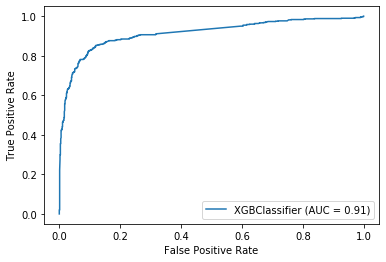

In [9]:
rf_disp = plot_roc_curve(xgb, xTest_xgb, yTest_xgb)
plt.show()

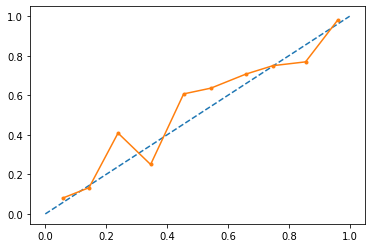

In [55]:
predictions = xgb.predict_proba(xTest_xgb)[:,1]
# reliability diagram
fop, mpv = calibration_curve(yTest_xgb, predictions, n_bins=10, normalize=True)
# plot perfectly calibrated
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot calibrated reliability
pyplot.plot(mpv, fop, marker='.')
pyplot.show()

In [22]:
brier_score_loss(yTest_xgb, predictions)

0.10300436304889261

In [23]:
calibrated = CalibratedClassifierCV(xgb, method='isotonic', cv=5)
calibrated.fit(xTrain_xgb, (yTrain_xgb))

/Users/loicalix-brown/opt/anaconda3/lib/python3.7/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CalibratedClassifierCV(base_estimator=XGBClassifier(base_score=0.5,
                                                    booster='gbtree',
                                                    colsample_bylevel=1,
                                                    colsample_bytree=0.6,
                                                    gamma=0.5,
                                                    learning_rate=0.1,
                                                    max_delta_step=0,
                                                    max_depth=20,
                                                    min_child_weight=1,
                                                    missing=None,
                                                    n_estimators=100, n_jobs=1,
                                                    nthread=None,
                                                    objective='binary:logistic',
                                                    random_state=0, reg_alpha=0,

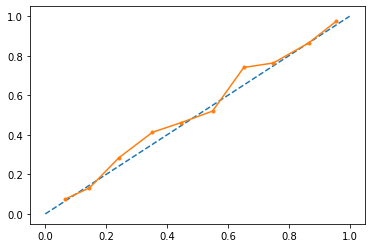

In [58]:
probs = calibrated.predict_proba(xTest_xgb)[:, 1]
# reliability diagram
fop, mpv = calibration_curve(yTest_xgb, probs, n_bins=10, normalize=False)
# plot perfectly calibrated
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot calibrated reliability
pyplot.plot(mpv, fop, marker='.')
pyplot.show()

In [27]:
brier_score_loss(yTest_xgb, probs)

0.10097460105550593

In [32]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'n_estimators' : [200,400,600,1000,1200,1800],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5,10,15,20]
        }

param_comb = 50
skf = StratifiedKFold(n_splits=10, shuffle = True, random_state = 1001)
xgb = XGBClassifier(learning_rate=0.02, objective='binary:logistic',
                    silent=True, nthread=1)
model = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='neg_brier_score', n_jobs=4, cv=3, verbose=3, random_state=1001 )
search = model.fit(xTrain_xgb, yTrain_xgb)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    9.1s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:  1.4min finished
/Users/loicalix-brown/opt/anaconda3/lib/python3.7/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/loicalix-brown/opt/anaconda3/lib/python3.7/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [33]:
search.best_params_

{'subsample': 0.6,
 'n_estimators': 1200,
 'min_child_weight': 1,
 'max_depth': 15,
 'gamma': 5,
 'colsample_bytree': 1.0}

In [34]:
search.best_score_

-0.10408136662816621

In [36]:
from xgboost import XGBClassifier

xgb = XGBClassifier(subsample = 0.6, min_child_weight = 1, max_depth = 15, gamma = 5, colsample_bytree = 1, n_estimators = 1200)
kf = StratifiedKFold(n_splits=100, random_state=1001, shuffle=True)

xgb.fit(xTrain_xgb,ravel(yTrain_xgb))
yPred_xgb = xgb.predict(xTest_xgb)

In [37]:
yTrue, yPred = yTest_xgb , xgb.predict(xTest_xgb)

from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(yTrue, yPred))

Results on the test set:
              precision    recall  f1-score   support

         0.0       0.86      0.92      0.89       848
         1.0       0.88      0.79      0.83       599

    accuracy                           0.87      1447
   macro avg       0.87      0.86      0.86      1447
weighted avg       0.87      0.87      0.87      1447



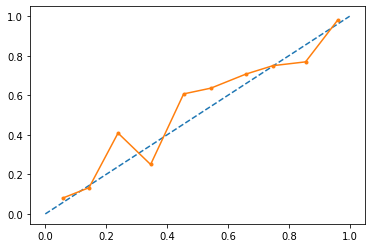

In [38]:
predictions = xgb.predict_proba(xTest_xgb)[:,1]
# reliability diagram
fop, mpv = calibration_curve(yTest_xgb, predictions, n_bins=10, normalize=True)
# plot perfectly calibrated
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot calibrated reliability
pyplot.plot(mpv, fop, marker='.')
pyplot.show()

In [39]:
brier_score_loss(yTest_xgb, predictions)

0.10085697273836097

In [49]:
calibrated = CalibratedClassifierCV(xgb, method='isotonic', cv=5)
calibrated.fit(xTrain_xgb, (yTrain_xgb))

/Users/loicalix-brown/opt/anaconda3/lib/python3.7/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CalibratedClassifierCV(base_estimator=XGBClassifier(base_score=0.5,
                                                    booster='gbtree',
                                                    colsample_bylevel=1,
                                                    colsample_bytree=1, gamma=5,
                                                    learning_rate=0.1,
                                                    max_delta_step=0,
                                                    max_depth=15,
                                                    min_child_weight=1,
                                                    missing=None,
                                                    n_estimators=1200, n_jobs=1,
                                                    nthread=None,
                                                    objective='binary:logistic',
                                                    random_state=0, reg_alpha=0,
                                                    re

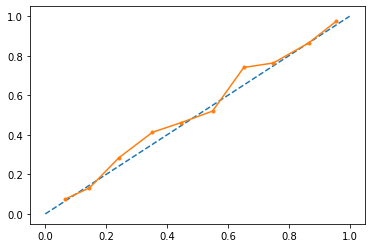

In [59]:
probs = calibrated.predict_proba(xTest_xgb)[:, 1]

# reliability diagram
fop, mpv = calibration_curve(yTest_xgb, probs, n_bins=10, normalize=False)
# plot perfectly calibrated
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot calibrated reliability
pyplot.plot(mpv, fop, marker='.')
pyplot.show()

In [60]:
brier_score_loss(yTest_xgb, probs)

0.10068181530092897